# About

This is a reproduction of the NIPS paper "Self-Normalizing Neural Networks". The NIPS version of the paper can be found here: https://papers.nips.cc/paper/6698-self-normalizing-neural-networks.pdf

Supplementary material can be found here: https://papers.nips.cc/paper/6698-self-normalizing-neural-networks-supplemental.zip

Alternatively, the arxiv version contains both, but has some slight differences with the NIPS paper (and is a bit older): https://arxiv.org/abs/1706.02515

This implementation is under the MIT license: https://github.com/AdrienLE/SNN_repro/blob/master/LICENSE

As well as implementing a custom version of SNN, it reproduces the UCI experiments present in the original paper. Due to lack of time and computational resources, it does not reproduce the Tox21 and HTRU2 parts, but UCI is arguably the most significant anyway since it covers a staggering 121 datasets!

Because this is a submission to Nurture.AI, I will not update this particular repository. However, please look in my other github projects in the near future to find an updated version that will include:
- A link to download my processed data
- Further experiments, including Tox21 and HTRU2

In [1]:
from scipy.io.arff import loadarff
from scipy.io import mmread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import DataLoader, TensorDataset
import glob
import os
import numpy as np
import sklearn.model_selection
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
import math
import pickle
import random
import multiprocessing
import collections
import pandas as pd
import scipy.stats
import hashlib
import gzip
from IPython.display import display

# Note: this is just a progress bar library, if you don't have it,
# you can either install it or simply replace tqdm by the identity
# function.
SHOW_TQDM = True

def tqdm(*args, **kwargs):
    try:
        from tqdm import tqdm_notebook
    except Exception:
        return args[0]
    if SHOW_TQDM:
        return tqdm_notebook(*args, **kwargs)
    else:
        return args[0]

We set some global variables which will allow us to parallelize some of the work involved. If you only want to use a single notebook to do the processing, use BUCKET = 0 and N_BUCKETS = 1, otherwise change these variables to create as many buckets as you want and clone the notebook to create copies that will process the different buckets, potentially on different cuda devices.

In [2]:
BUCKET = 0
N_BUCKETS = 1
CUDA_DEVICE = 0

USE_CUDA = True

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


# Datasets

## UCI

### Downloads

> We used data sets and preprocessing scripts by Fernández-Delgado et al. [10] for data preparation and defining training and test sets. With several flaws in the method comparison[37] that we avoided, the authors compared 179 machine learning methods of 17 groups in their experiments.

[10] http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf

[37] http://www.jmlr.org/papers/volume17/15-374/15-374.pdf

Data available at: http://persoal.citius.usc.es/manuel.fernandez.delgado/papers/jmlr/data.tar.gz

In [3]:
# Download the uci datasets
!mkdir -p datasets/uci
!cd datasets/uci && wget -nc http://persoal.citius.usc.es/manuel.fernandez.delgado/papers/jmlr/data.tar.gz
!cd datasets/uci && tar xkf data.tar.gz 2>&1 | head -n 5 && echo ...

File ‘data.tar.gz’ already there; not retrieving.

tar: abalone/conxuntos_kfold.dat: Cannot open: File exists
tar: abalone/abalone.arff: Cannot open: File exists
tar: abalone/abalone.data: Cannot open: File exists
tar: abalone/abalone.names: Cannot open: File exists
tar: abalone/abalone.cost: Cannot open: File exists
...


In [4]:
def uci_folder_to_name(f):
    return f.split('/')[-1]

uci_folders = sorted(set([
    '/'.join(f.split('/')[:-1]) for f in glob.glob('datasets/uci/*/*.arff')
]))

random.shuffle(uci_folders)

# We get 121 datasets, the expected amount
len(uci_folders), uci_folder_to_name(uci_folders[14])

(121, 'seeds')

In [5]:
# Seems like molec-biol-protein-second hasn't been preprocessed... oh well.
set(glob.glob('datasets/uci/*')) - set(uci_folders)

{'datasets/uci/data.tar.gz', 'datasets/uci/molec-biol-protein-second'}

### Train/Test

[10] says:

>  The indexes of the training and test patterns (i.e., the
data partitioning) are given by the file conxuntos.dat for each data set, and are the same
for all the classifiers. Then, using the selected values for the tunable parameters, a 4-fold
cross validation is developed using the whole available data. The indexes of the training
and test patterns for each fold are the same for all the classifiers, and they are listed in
the file conxuntos kfold.dat for each data set. The test results is the average over the 4
test sets. However, for some data sets, which provide separate data for training and
testing (data sets annealing and audiology-std, among others), the classifier (with the
tuned parameter values) is trained and tested on the respective data sets.

This is ambiguous because it isn't clear whether to use the 4-fold version or the training and test set. Based on [37] and my understanding of what is said in the main paper, I will assume that we should use the training/test set defined in `conxuntos.dat` and ignore the 4-fold cross-validation. Eg the main paper says:

> For the UCI data sets, the best hyperparameter setting was determined by a grid-search over all hyperparameter combinations using 15% of the training data as validation set.

In [6]:
def line_to_idx(l):
    return np.array([int(e) for e in l.split()], dtype=np.int32)

def load_uci_dataset(folder, train=True):
    full_file = f'{folder}/{uci_folder_to_name(folder)}.arff'
    if os.path.exists(full_file):
        data = loadarff(full_file)
        train_idx, test_idx = [line_to_idx(l) for l in open(f'{folder}/conxuntos.dat').readlines()]
        assert len(set(train_idx) & set(test_idx)) == 0
        all_idx = list(train_idx) + list(test_idx)
        assert len(all_idx) == np.max(all_idx) + 1
        assert np.min(all_idx) == 0
        if train:
            data = (data[0][train_idx], data[1])
        else:
            data = (data[0][test_idx], data[1])
    else:
        typename = 'train' if train else 'test'
        filename = f'{folder}/{uci_folder_to_name(folder)}_{typename}.arff'
        data = loadarff(filename)
    assert data[1].types() == ['numeric'] * (len(data[1].types()) - 1) + ['nominal']
    X = np.array(data[0][data[1].names()[:-1]].tolist())
    y = np.array([int(e) for e in data[0][data[1].names()[-1]]])
    return X.astype(np.float32), y

def uci_validation_set(X, y):
    return sklearn.model_selection.train_test_split(X, y, test_size=0.15, random_state=0)

## Tox21

### Downloads

> For the Tox21 data set, the best hyperparameter setting was determined by a grid-search over all hyperparameter combinations using the validation set defined by the challenge winners (Mayr et al., 2016). 

Paper: https://arxiv.org/pdf/1503.01445.pdf

I assume this also means that they used the processed dataset provided by the winners as well, available at: http://bioinf.jku.at/research/DeepTox/tox21.html

In [7]:
!mkdir -p datasets/tox21
!cd datasets/tox21 && wget -nc http://bioinf.jku.at/research/DeepTox/tox21.zip
!cd datasets/tox21 && unzip -f tox21.zip

File ‘tox21.zip’ already there; not retrieving.

Archive:  tox21.zip


### Train/Test/Validation

The paper is ambiguous because it talks about using "the validation set defined by the challenge winners", but the challenge winners used *cross-validation*. Two possibilities on what this means:

- The self-norm paper uses a single fold of the cross-validation as its validation set or simply created its own validation set based on the principles outlined in the paper, in which case the type of validation set is what really matters.
- The self-norm paper actually does use the same cross-validation but doesn't mention it in those words. This is weird because it mentions cross-validation elsewhere.

I will assume the former possibility, in part because it is simpler to implement.

In [8]:
FILE_CACHE = {}

In [9]:
def c_csv(*args, **kwargs):
    if args[0] not in FILE_CACHE:
        FILE_CACHE[args[0]] = pd.read_csv(*args, **kwargs)
    return FILE_CACHE[args[0]]

def c_mmread(*args, **kwargs):
    if args[0] not in FILE_CACHE:
        FILE_CACHE[args[0]] = mmread(*args, **kwargs)
    return FILE_CACHE[args[0]]

def load_tox21(effect_label, typ='train', cvfold=0.0):
    pref = 'datasets/tox21/'
    # Code based on the sample code given here: http://bioinf.jku.at/research/DeepTox/sampleCode.py
    y_tr = c_csv(pref + 'tox21_labels_train.csv.gz', index_col=0, compression="gzip")
    y_te = c_csv(pref + 'tox21_labels_test.csv.gz', index_col=0, compression="gzip")
    x_tr_dense = c_csv(pref + 'tox21_dense_train.csv.gz', index_col=0, compression="gzip").values
    x_te_dense = c_csv(pref + 'tox21_dense_test.csv.gz', index_col=0, compression="gzip").values
    x_tr_sparse = c_mmread(pref + 'tox21_sparse_train.mtx.gz').tocsc()
    x_te_sparse = c_mmread(pref + 'tox21_sparse_test.mtx.gz').tocsc()
    
    compound_data = c_csv(pref + 'tox21_compoundData.csv', index_col=0)
    tr_cv = c_csv(pref + 'tox21_dense_train.csv.gz', index_col=0, compression="gzip").join(compound_data)

    # filter out very sparse features
    sparse_col_idx = ((x_tr_sparse > 0).mean(0) > 0.05).A.ravel()
    x_tr = np.hstack([x_tr_dense, x_tr_sparse[:, sparse_col_idx].A])
    x_te = np.hstack([x_te_dense, x_te_sparse[:, sparse_col_idx].A])

    target = y_tr.columns[effect_label]
    rows_tr = np.isfinite(y_tr[target]).values
    rows_val = tr_cv['CVfold'] == cvfold
    rows_te = np.isfinite(y_te[target]).values

    if typ == 'train':
        res = x_tr[rows_tr & (~rows_val)], y_tr[target][rows_tr & (~rows_val)]
    elif typ == 'val':
        res = x_tr[rows_tr & (rows_val)], y_tr[target][rows_tr & (rows_val)]
    else:
        res = x_te[rows_te], y_te[target][rows_te]
    X, y = [np.array(r) for r in res]
    return X.astype(np.float32), y.astype(np.int32)

In [10]:
X, y = load_tox21(5, typ='train')
X.shape

(7748, 1644)

# Models

## Hyperparameters

Given in supplement S4.

In [11]:
UCI_HYPER = {
    'SNN': {
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.05, 0.0],
        'form': ['rect', 'conic'],
        'activation': ['selu']
    },
    'MSRAinit': {  # Note: same as above except dropout
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.5, 0.0],
        'form': ['rect', 'conic'],
        'activation': ['relu']
    },
    'BatchNorm': { # Note: no dropout, batchnorm
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['batchnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'WeightNorm' : { # Note: same as above, weightnorm
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['weightnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'LayerNorm': { # Note: same as above, layernorm
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['layernorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'Highway': {
        'type': ['highway'],
        'layers': [2, 3, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.5, 0.0],
        'activation': ['relu']  # ?
    },
    'ResNet': {
        'type': ['resnet'],
        'units': [1024, 512, 256],
        'layers': [2, 3, 4, 8, 16],
        'lr': [0.01, 0.1, 1.0],
        'bottleneck': [0.25, 0.5],
        'form': ['rect', 'diavolo'],
        'activation': ['relu']  # ?
    },
}

TOX21_HYPER = {
    'SNN': {
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'dropout': [0.05, 0.1],
        'form': ['rect', 'conic'],
        'activation': ['selu'],
        'l2': [0.001, 0.0001, 0.00001],
    },
    'MSRAinit': {  # Note: same as above except dropout
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'dropout': [0.5, 0.0],
        'form': ['rect', 'conic'],
        'activation': ['relu'],
        'l2': [0.001, 0.0001, 0.00001],
    },
    'BatchNorm': { # Note: no dropout, batchnorm
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'norm': ['batchnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu'],  # ?
        'l2': [0.001, 0.0001, 0.00001],
    },
    'WeightNorm' : { # Note: same as above, weightnorm
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'norm': ['weightnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu'],  # ?
        'l2': [0.001, 0.0001, 0.00001],
    },
    'LayerNorm': { # Note: same as above, layernorm
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'norm': ['layernorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu'],  # ?
        'l2': [0.001, 0.0001, 0.00001],
    },
    'Highway': {
        'type': ['highway'],
        'layers': [2, 3, 4, 6, 8, 16, 32],
        'lr': [0.01, 0.05, 0.1],
        'dropout': [0.5, 0.0],
        'activation': ['relu'],  # ?
        'l2': [0.001, 0.0001, 0.00001],
    },
    'ResNet': {
        'type': ['resnet'],
        'units': [1024, 2048],
        'layers': [2, 3, 4, 6, 8, 16],
        'lr': [0.01, 0.05, 0.1],
        'bottleneck': [0.25, 0.5],
        'form': ['rect', 'diavolo'],
        'activation': ['relu'],  # ?
        'l2': [0.001, 0.0001, 0.00001],
    },
}

HTRU2_HYPER = {
    'SNN': {
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.05, 0.0],
        'form': ['rect', 'conic'],
        'activation': ['selu']
    },
    'MSRAinit': {  # Note: same as above except dropout
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.5, 0.0],
        'form': ['rect', 'conic'],
        'activation': ['relu']
    },
    'BatchNorm': { # Note: no dropout, batchnorm
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['batchnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'WeightNorm' : { # Note: same as above, weightnorm
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['weightnorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'LayerNorm': { # Note: same as above, layernorm
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'norm': ['layernorm'],
        'form': ['rect', 'conic'],
        'activation': ['relu']  # ?
    },
    'Highway': {
        'type': ['highway'],
        'layers': [2, 4, 8, 16, 32],
        'lr': [0.01, 0.1, 1.0],
        'dropout': [0.5, 0.0],
        'activation': ['relu']  # ?
    },
    'ResNet': {
        'type': ['resnet'],
        'units': [1024, 512, 256],
        'layers': [2, 4, 8, 16],
        'lr': [0.01, 0.1, 1.0],
        'bottleneck': [0.25, 0.5],
        'form': ['rect', 'diavolo'],
        'activation': ['relu']  # ?
    },
}

## Initialization

> Initialization. Since SNNs have a fixed point at zero mean and unit variance for normalized weights ω =?n
i=1 wi = 0 and τ =?n i=1 w2 i = 1 (see above), we initialize SNNs such that these constraints
are fulfilled in expectation. We draw the weights from a Gaussian distribution with E(wi) = 0 and variance Var(wi) = 1/n. Uniform and truncated Gaussian distributions with these moments led to networks with similar behavior. The “MSRA initialization” is similar since it uses zero mean and variance 2/n to initialize the weights [17]. The additional factor 2 counters the effect of rectified linear units.

Initialization names are all over the place, but at least it is clear what initialization they use for their own networks and for ReLU networks. The initialization given here is more or less the one given by kaiming_normal in torch.nn.init, but we either need to call it in counterintuitive ways or to modify it.

In [12]:
def init_tensor(tensor, nonlinearity, mode='fan_in'):
    """
    Modified version of kaiming_normal from torch.nn.init that can handle the selu nonlinearity properly.
    """
    if isinstance(tensor, autograd.Variable):
        init_tensor(tensor.data, nonlinearity, mode=mode)
        return tensor

    if nonlinearity == 'selu':
        nonlinearity = 'linear'
    fan = nn.init._calculate_correct_fan(tensor, mode)
    gain = nn.init.calculate_gain(nonlinearity)
    std = gain / math.sqrt(fan)
    return tensor.normal_(0, std)


## Neural Net

### Feedforward

The paper does not discuss the following:
- Batch size (the concept does not appear at all)
- Optimizers: the NIPS version does mention optimizers a little, but does not explain which one was used for the experiments.

Specifically this is all the paper says on optimizers:

> Empirically, we found that SGD, momentum, Adadelta and Adamax worked well for training SNNs, whereas for Adam we had to adjust the parameters (β2 = 0.99, epsilon = 0.01) to obtain proficient networks.

Basically it sounds like all these optimizers can work, but which one was actually used? This is highly relevant for the learning rate!

For now, we will assume regular SGD as the optimizer (no momentum, since no momentum shows up in the hyperparameters), and 64 as the batch size.

TODO: experiment with more different optimizers and batch sizes.

In addition, it is not fully clear what activation function is used by the different networks, except for SNN and MSRAinit, which are clearly using SeLU and ReLU, respectively. We will assume that all other networks are also using ReLU, as is most likely.

In [13]:
class SeLU(nn.Module):
    # Custom implementation of SeLU. Note that an equivalent implementation
    # exists in pytorch as nn.SELU
    def __init__(self, lambd=1.0507, alpha=1.67326):
        super().__init__()
        self.lambd = lambd
        self.alpha = alpha
        
    def forward(self, x):
        mask = (x > 0).type(x.data.type())
        return self.lambd * (
            (x * mask) +
            ((self.alpha * torch.exp(x) - self.alpha) * (1 - mask))
        )

class AlphaDropout(nn.Module):
    # Custom implementation of alpha dropout. Note that an equivalent
    # implementation exists in pytorch as nn.AlphaDropout
    def __init__(self, dropout, lambd=1.0507, alpha=1.67326):
        super().__init__()
        self.lambd = lambd
        self.alpha = alpha
        self.aprime = -lambd * alpha
        
        self.q = 1 - dropout
        self.p = dropout

        self.a = (self.q + self.aprime**2 * self.q * self.p)**(-0.5)
        self.b = -self.a * (self.p * self.aprime)
        
    def forward(self, x):
        if not self.training:
            return x
        ones = torch.ones(x.size())
        if x.is_cuda:
            ones = ones.cuda()
        mask = torch.bernoulli(ones * self.p)
        x = x.masked_fill(autograd.Variable(mask.byte()), self.aprime)
        return x * self.a + self.b
    
ACTIVATIONS = {
    'relu': nn.ReLU,
    'selu': SeLU
}

OPTIMIZER_CLASS = optim.SGD
BATCH_SIZE = 64

class LayerNorm(nn.Module):
    # Stolen from https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True, unbiased=False)  # Note: unbiased=False to prevent divide by 0 errors.
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class Layer(nn.Module):
    def __init__(self, input_size, output_size, activation, normalization, dropout, is_highway):
        super().__init__()

        self.highway_lin = None
        if is_highway:
            assert input_size == output_size
            self.highway_lin = nn.Linear(output_size, output_size)
        
        ident = lambda x: x
        self.lin = nn.Linear(input_size, output_size)
        init_tensor(self.lin.weight, activation)
        self.activation = ACTIVATIONS[activation]()
        if dropout > 0.0:
            if activation != 'selu':
                self.dropout = nn.Dropout(dropout)
            else:
                self.dropout = AlphaDropout(dropout)
        else:
            self.dropout = ident
        if normalization == 'batchnorm':
            self.normalization = nn.BatchNorm1d(output_size)
        elif normalization == 'weightnorm':
            self.normalization = ident
            self.lin = nn.utils.weight_norm(self.lin)
        elif normalization == 'layernorm':
            self.normalization = LayerNorm(output_size)
        elif normalization is None:
            self.normalization = ident
        else:
            raise ValueError(f'Unknown normalization {normalization}')
                    
    def forward(self, x):
        activations = self.activation(self.lin(x))
        if self.highway_lin is not None:
            act_mul = F.sigmoid(self.highway_lin(x))
            activations = act_mul*activations + (1 - act_mul)*x
        
        # Note: we use normalization AFTER the activation. The reason for this is twofold:
        # 1/ This is the proper way to use layernorm and although it is not the "official" way to
        #    use batchnorm, it is known to work better.
        # 2/ It is likely the way it was done in the paper since when I tried doing it before the
        #    activation I found that layernorm and batchnorm had performances that differed
        #    significantly from the paper.
        return self.dropout(self.normalization(activations))

class ResNetLayer(nn.Module):
    def __init__(self, input_size, n_nodes, bottleneck):
        super().__init__()
        
        # First if we are the first block, we need to make the input the same
        # size as n_nodes.
        self.init_layers = nn.ModuleList()
        if input_size != n_nodes:
            self.init_layers.append(nn.Linear(input_size, n_nodes))
            self.init_layers.append(nn.BatchNorm1d(n_nodes))
            self.init_layers.append(nn.ReLU())
            input_size = n_nodes
        
        # Important note: here we assume that the "number of neuron per block"
        # is in fact the number of neurons within a non-bottleneck layer of 
        # each block. Reasons to make this assumption include:
        # 1/ The math doesn't work out if the numbers given are really the
        #    total number of neurons across the 2 or 3 blocks! For instance,
        #    a layer with 256 neurons and a bottleneck of 50% would need 102.4
        #    neurons in the two outside layers and 51.2 in the bottleneck layer
        #    (of course this could be done with some rounding, but the fact that
        #    no such thing is mentioned indicates that this wasn't done).
        # 2/ The maximum number of blocks for ResNet is 16, which is twice as
        #    little as the maximum number of layers for other networks. This
        #    squares well with the fact that Resnet contains 2 (or 3) layers per 
        #    block.
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_size, n_nodes))
        input_size = n_nodes
        # Note: unlike in the other layers, we put it before the activation to
        # follow the ResNet paper more closely.
        self.layers.append(nn.BatchNorm1d(n_nodes))
        self.layers.append(nn.ReLU())
        
        if bottleneck is not None:
            bottleneck_size = int(n_nodes * bottleneck)
            self.layers.append(nn.Linear(input_size, bottleneck_size))
            input_size = bottleneck_size
            self.layers.append(nn.BatchNorm1d(bottleneck_size))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(input_size, n_nodes))
        self.layers.append(nn.BatchNorm1d(n_nodes))
        
    def forward(self, x):
        for l in self.init_layers:
            x = l(x)
        y = x
        for l in self.layers:
            y = l(y)
        y += x
        return F.relu(y)
    
class FNN(nn.Module):
    def __init__(self, n_features, n_classes, description):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.description = description
        self.layers = nn.ModuleList()
        if 'units' not in description:
            assert description.get('type') == 'highway'
        n_nodes = description.get('units', n_features)
        input_size = n_features
        for _ in range(description['layers']):
            if description.get('type') == 'resnet':
                if description['form'] == 'rect':
                    assert description.get('bottleneck') is None
                else:
                    assert description.get('bottleneck') is not None
                self.layers.append(
                    ResNetLayer(
                        input_size, n_nodes,
                        description.get('bottleneck')
                    )
                )
            else:
                self.layers.append(
                    Layer(
                        input_size, n_nodes,
                        description['activation'],
                        description.get('norm'),
                        description.get('dropout', 0.0),
                        description.get('type') == 'highway'
                    )
                )
            input_size = n_nodes
            if description.get('form') == 'conic':
                n_nodes = max(1, n_nodes // 2)  # TODO: figure out if this is correct
        self.layers.append(nn.Linear(input_size, n_classes))
        self.layers.append(nn.LogSoftmax())
    
    def forward(self, x):
        for i, l in enumerate(self.layers):
            x = l(x)
        return x

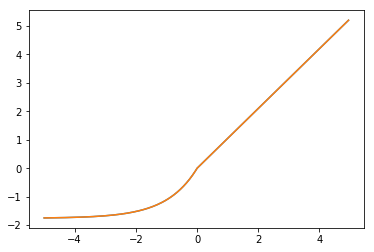

In [14]:
# Let's check that SeLU actually looks like it should
s = SeLU()
x = autograd.Variable(torch.from_numpy(np.arange(-5, 5, 0.05)))
plt.plot(x.data.numpy(), s(x).data.numpy())
plt.plot(x.data.numpy(), nn.SELU()(x).data.numpy())

# If a single line shows, our implementation is roughly equivalent to that
# in pytorch, which is a good sign

Note: the test below can sometimes fail due to some long encoding error. If it happens, you can try to restart the notebook and try again. If it keeps happening, just comment out the test.

In [15]:
TEST_SIZE = 1000000

for p in [0.0, 0.01, 0.05, 0.1, 0.5, 0.99]:
    # Let's check AlphaDropout vs Torch's AlphaDropout
    inp = autograd.Variable(torch.normal(torch.zeros(TEST_SIZE), torch.ones(TEST_SIZE)))
    init_seed = torch.initial_seed()
    torch.manual_seed(0)
    out1 = nn.AlphaDropout(p)(inp)
    torch.manual_seed(0)
    out2 = AlphaDropout(p)(inp)
    torch.manual_seed(init_seed)


    # If this is true, we are returning identical results to nn.AlphaDropout,
    # which means this is probably correct.
    # Note: the reason why we don't get exactly the same numbers is that
    # this implementation uses the alpha and lambda given in the paper,
    # whereas pytorch uses a lot more significant digits.
    print(np.sum(np.abs(out1.data.numpy() - out2.data.numpy()) < 1e-4) == inp.size()[0]) 

    # In both cases the first number should be close to 0 and the second
    # close to 1
    print(out1.mean().data.numpy(), out1.std().data.numpy())
    print(out2.mean().data.numpy(), out2.std().data.numpy())

True
[0.00014227] [1.0005734]
[0.00014227] [1.0005734]
True
[0.00011501] [1.000579]
[0.00011503] [1.000579]
True
[0.00073029] [1.0001725]
[0.00073028] [1.0001725]
True
[0.00038914] [1.0006398]
[0.00038912] [1.0006398]
True
[0.00117923] [1.000866]
[0.00117918] [1.000866]
True
[0.00026518] [1.0038487]
[0.00026417] [1.0038487]


# Experiments

## UCI

> For the UCI data sets, the best hyperparameter setting was determined by a grid-search over all hyperparameter combinations using 15% of the training data as validation set. The early stopping parameter was determined on the smoothed learning curves of 100 epochs of the validation set. Smoothing was done using moving averages of 10 consecutive values.

...

> If multiple hyperparameters provided identical performance on the validation set, we preferred settings with a higher number of layers, lower learning rates and higher dropout rates.

My understanding of the first statement: we run training with a validation set for 100 epochs, find the best hyperparameters and number of epochs based on the moving average of the last 10 epochs in validation accuracy (note: could be loss instead, not sure). If we have identical values, we bias towards more layers, lower learning rate, higher dropout rate and (assumption) fewer epochs.

First, we write some quick code to handle pickling intermediate results in the `pickled/uci` folder. This is to not have to re-run everything if training crashes, since it takes days to finish.

In [16]:
!mkdir -p pickled/uci

def get_uci_cache_filename(folder, params, has_val, has_test, epochs, n_test, metric):
    uci_name = uci_folder_to_name(folder)
    filename = []
    for k in sorted(params.keys()):
        filename.append(f'{k}_{params[k]}')
    filename += [str(has_val), str(has_test), str(epochs)]
    if has_test:
        filename = ['correct'] + filename
    if n_test > 1:
        filename = [f'tests_{n_test}'] + filename
    if metric != 'acc':
        filename.append(metric)
    filename = ':'.join(filename)
    if 'selu' in filename and has_test:
        filename += 'v2'  # To handle a fix in the implementation of SeLU
    return f'pickled/uci/{uci_name}/{filename}'

All the code to evaluate, fit and extract the performance.

In [17]:
def score_key(score):
    # Note: we assume that we sort in a descending way
    param, epochs, score = score
    return (score, param['layers'], -param['lr'], param.get('dropout', 0.0), -epochs)

def evaluate(net, val_loader, metric='acc'):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for batch, labels in val_loader:
        batch = w(autograd.Variable(batch))
        labels = labels.cuda()
        outputs = net(batch)
        _, predictions = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum()
        all_labels += list(labels)
        all_preds += list(predictions)
    if metric == 'acc':
        return correct / total
    if metric == 'auc':
        return roc_auc_score(all_labels, all_preds)

class Uncached(Exception):
    pass

N_TEST = 10

def fit(folder, features, classes, params, train_loader, val_loader, test_loader, epochs=100, force_cached=False, metric='acc'):
    if val_loader is None and test_loader is not None:
        n_test = N_TEST
    else:
        n_test = 1
    filename = get_uci_cache_filename(folder, params, val_loader is not None, test_loader is not None, epochs, n_test, metric)
    if os.path.exists(filename):
        results = pickle.load(open(filename, 'rb'))
        if results[0] == 0:  # version number
            comb, test_acc = results[1:]
            if not isinstance(test_acc, list):
                test_acc = [test_acc]
            return comb, test_acc
    if force_cached:
        raise Uncached
    
    all_combinations = []
    all_test_accs = []
    
    for _ in range(n_test):
        net = w(FNN(features, classes, params))
        criterion = w(nn.NLLLoss())
        optimizer = optim.SGD(net.parameters(), lr=params['lr'], weight_decay=params.get('l2', 0.0))

        for epoch in range(epochs):
            net.train()
            for batch, labels in train_loader:
                batch = w(autograd.Variable(batch))
                labels = w(autograd.Variable(labels))
                optimizer.zero_grad()  # TODO: check if this is useful.
                outputs = net(batch)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            if val_loader is not None:
                accuracy = evaluate(net, val_loader, metric)
                all_combinations.append((params, epoch + 1, accuracy))

        test_acc = 0.0
        if test_loader is not None:
            test_acc = evaluate(net, test_loader, metric)
            all_test_accs.append(test_acc)
    
    pickle.dump((0, all_combinations, all_test_accs), open(filename, 'wb'))
    return all_combinations, all_test_accs

def make_loader(X, y, transformer=None, batch_size=BATCH_SIZE):
    if transformer is None:
        transformer = sklearn.preprocessing.StandardScaler()
        transformer.fit(X)
    X = transformer.transform(X)
    return DataLoader(
        dataset=TensorDataset(*[w(torch.from_numpy(e)) for e in [X, y]]),
        batch_size=batch_size,
        shuffle=transformer is None
    ), transformer

def get_performance(X, y, Xtest, ytest, parameters, folder, variant, force_cached=False, metric='acc', train_val=None, force_depth=None):
    
    features = X.shape[-1]
    classes = len(set(y))

    if train_val is not None:
        Xtrain, Xval, ytrain, yval = train_val
    else:
        Xtrain, Xval, ytrain, yval = uci_validation_set(X, y)
    batch_size = BATCH_SIZE
    if len(ytrain) > 1000:
        batch_size = 512
    
    train_loader_small, transformer = make_loader(Xtrain, ytrain, batch_size=batch_size)
    val_loader, _ = make_loader(Xval, yval, transformer, batch_size=batch_size)
    train_loader_big, transformer = make_loader(X, y, batch_size=batch_size)
    test_loader, _ = make_loader(Xtest, ytest, transformer, batch_size=batch_size)
    
    all_combinations = []
    all_params = list(sklearn.model_selection.ParameterGrid(parameters))
    random.shuffle(all_params)
    for params in tqdm(all_params, desc=variant):
        if force_depth is not None and params['layers'] != force_depth:
            continue
        if 'bottleneck' in params and params['form'] == 'rect':
            del params['bottleneck']  # A rectangular resnet doesn't have a bottleneck
        comb_list = fit(folder, features, classes, params, train_loader_small, val_loader, None, force_cached=force_cached, metric=metric)[0]
        # The comb_list at this point does not have a smoothed learning curve, make it so
        new_comb_list = []
        last_10 = [0.0] * 10
        for params, epochs, val_score in comb_list:
            last_10.pop(0)
            last_10.append(val_score)
            assert len(last_10) == 10
            new_comb_list.append((params, epochs, np.mean(last_10)))
        all_combinations += new_comb_list

    best_params, best_epochs, val_score = max(all_combinations, key=score_key)
    return (
        best_params, best_epochs, val_score,
        fit(folder, features, classes, best_params, train_loader_big, None, test_loader, best_epochs, metric=metric)[1]
    )
    

def process_folder(folder, force_cached=False):
    X, y = load_uci_dataset(folder)
    
    print(f'{uci_folder_to_name(folder)}: {len(y)} training samples')
    Xtest, ytest = load_uci_dataset(folder, False)

    try:
        os.makedirs(f'pickled/uci/{uci_folder_to_name(folder)}')
    except Exception:
        pass
        
    perf = {}
    for variant in tqdm(random.sample(list(UCI_HYPER), len(UCI_HYPER)), uci_folder_to_name(folder)):
        if not force_cached:
            cur_name = folder + '::' + variant
            bucket = int(hashlib.md5(cur_name.encode('utf8')).hexdigest(), 16) % N_BUCKETS
            if bucket != BUCKET:
                continue
        perf[variant] = get_performance(X, y, Xtest, ytest, UCI_HYPER[variant], folder, variant, force_cached)
    return perf

In [18]:
for folder in tqdm(uci_folders, 'Everything'):
    with torch.cuda.device(CUDA_DEVICE):
        process_folder(folder)

Now we extract all the data from the pickle files.

In [19]:
def processed_to_pandas_format(processed):
    KEY_MAP = {
        'BatchNorm': 'BN',
        'LayerNorm': 'LN',
        'MSRAinit': 'MS',
        'SNN': 'SNN',
        'WeightNorm': 'WN',
        'Highway': 'HW',
        'ResNet': 'ResNet'
    }
    res = {}
    for k in processed:
        res[KEY_MAP[k]] = processed[k][-1]
    return res

all_perf = {}
SHOW_TQDM = True
for folder in tqdm(uci_folders, 'Everything'):
    SHOW_TQDM = False
    try:
        all_perf[uci_folder_to_name(folder)] = processed_to_pandas_format(process_folder(folder, True))
    except Uncached:
        pass
    
SHOW_TQDM = True

musk-2: 3299 training samples
post-operative: 45 training samples
breast-cancer: 143 training samples
statlog-australian-credit: 345 training samples
titanic: 1101 training samples
hill-valley: 606 training samples
oocytes_trisopterus_nucleus_2f: 456 training samples
spambase: 2301 training samples
spect: 79 training samples
libras: 180 training samples
energy-y2: 384 training samples
iris: 75 training samples
primary-tumor: 165 training samples
congressional-voting: 218 training samples
seeds: 105 training samples
echocardiogram: 66 training samples
led-display: 500 training samples
soybean: 307 training samples
lenses: 12 training samples
molec-biol-splice: 1595 training samples
heart-switzerland: 62 training samples
miniboone: 65032 training samples
waveform-noise: 2500 training samples
image-segmentation: 210 training samples
fertility: 50 training samples
chess-krvkp: 1598 training samples
lymphography: 74 training samples
oocytes_merluccius_nucleus_4d: 511 training samples
arrhyt

`UCI_details.csv` is a file containing data extracted from table S8 from the paper supplement. This contains the details of the performance of the different algorithms as given by the paper. This will allow us to reproduce the other tables based on the original performance data as well as to show the amount of difference that our data gets.

In [20]:
expected = pd.read_csv('UCI_details.csv', index_col=0).transpose().to_dict()

Compute the different metrics for both the old data and the newly computed data. We used 10 iterations on the test set in case I found out that the mean or max accuracy was needed, but in the end we only use the first accuracy, which is probably what was done in the paper

In [21]:
overlap = {}
old_ranks = collections.defaultdict(lambda: collections.defaultdict(list))
new_ranks = collections.defaultdict(lambda: collections.defaultdict(list))

AGGREGATOR = lambda x: x[0]

for k in expected:
    if k not in all_perf:
        continue
    tmp = {}
    old_order = []
    new_order = []
    for l in expected[k]:
        if l not in all_perf.get(k, {}):
            tmp[l] = expected[k][l]
        else:
            new_order.append((AGGREGATOR(all_perf[k][l]), l))
            cur_perf = AGGREGATOR(all_perf[k][l])
            tmp[l + ' (old/new)'] = f'{expected[k][l]:.4f}/{cur_perf:.4f} ({100*(cur_perf/expected[k][l] - 1):+.1f}%)'
            old_order.append((expected[k][l], l))
    overlap[k] = tmp
    old_order.sort(reverse=True)
    new_order.sort(reverse=True)
    for i, (_, name) in enumerate(old_order):
        old_ranks[expected[k]['N'] >= 1000][name].append(i + 1)
    for i, (_, name) in enumerate(new_order):
        new_ranks[expected[k]['N'] >= 1000][name].append(i + 1)

/home/adrien/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


### Table S8

First final reproduction: a version of table S8, with some changes to show the difference in accuracy between the original paper and my reproduction.

In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(pd.DataFrame.from_dict(overlap).transpose())

,BN (old/new),HW (old/new),LN (old/new),M,MS (old/new),N,ResNet (old/new),SNN (old/new),WN (old/new)
abalone,0.6303/0.5575 (-11.6%),0.6427/0.5383 (-16.2%),0.6178/0.6049 (-2.1%),9,0.6284/0.6130 (-2.4%),4177,0.6466/0.3463 (-46.4%),0.6657/0.3166 (-52.4%),0.6351/0.5465 (-14.0%)
acute-inflammation,1.0000/0.9667 (-3.3%),1.0000/0.6167 (-38.3%),0.9000/1.0000 (+11.1%),7,1.0000/1.0000 (+0.0%),120,1.0000/0.7000 (-30.0%),1.0000/1.0000 (+0.0%),1.0000/1.0000 (+0.0%)
acute-nephritis,1.0000/0.9333 (-6.7%),1.0000/0.5833 (-41.7%),1.0000/1.0000 (+0.0%),7,1.0000/1.0000 (+0.0%),120,1.0000/0.5833 (-41.7%),1.0000/1.0000 (+0.0%),1.0000/1.0000 (+0.0%)
annealing,0.1200/0.0600 (-50.0%),0.3600/0.6500 (+80.6%),0.5000/0.4700 (-6.0%),32,0.7300/0.7500 (+2.7%),898,0.2600/0.7400 (+184.6%),0.7600/0.1300 (-82.9%),0.6500/0.7700 (+18.5%)
arrhythmia,0.5929/0.5044 (-14.9%),0.6283/0.6062 (-3.5%),0.5752/0.6106 (+6.2%),263,0.6372/0.5929 (-6.9%),452,0.6460/0.4159 (-35.6%),0.6549/0.5973 (-8.8%),0.6018/0.5796 (-3.7%)
audiology-std,0.6400/0.5200 (-18.8%),0.7200/0.6400 (-11.1%),0.8000/0.8000 (+0.0%),60,0.6800/0.7200 (+5.9%),196,0.8000/0.5200 (-35.0%),0.8000/0.6800 (-15.0%),0.7200/0.7200 (+0.0%)
balance-scale,0.9231/0.4712 (-49.0%),0.9103/0.9679 (+6.3%),0.9872/0.9359 (-5.2%),5,0.9231/0.9615 (+4.2%),625,0.9167/0.4744 (-48.3%),0.9231/0.9679 (+4.9%),0.9551/0.9295 (-2.7%)
balloons,1.0000/0.3750 (-62.5%),0.2500/0.6250 (+150.0%),0.7500/0.5000 (-33.3%),5,0.5000/0.5000 (+0.0%),16,1.0000/0.8750 (-12.5%),1.0000/0.3750 (-62.5%),0.0000/0.7500 (+inf%)
bank,0.8823/0.8850 (+0.3%),0.8885/0.8221 (-7.5%),0.8920/0.8735 (-2.1%),17,0.8876/0.8854 (-0.2%),4521,0.8796/0.8801 (+0.1%),0.8903/0.8677 (-2.5%),0.8850/0.8664 (-2.1%)
blood,0.7647/0.7567 (-1.0%),0.7968/0.6765 (-15.1%),0.7112/0.2380 (-66.5%),5,0.7754/0.2380 (-69.3%),748,0.8021/0.5963 (-25.7%),0.7701/0.7674 (-0.4%),0.7594/0.7086 (-6.7%)


Note: we classify "big" and "small" datasets as having more or less than 1,000 elements, as in the paper. The paper is unclear on which bucket datasets with exactly 1,000 elements are in, but we should be able to reconstruct it using the fact that there are 75 small and 46 large datasets.

We find that datasets with 1,000 examples are considered LARGE.

In [23]:
sum([expected[e]['N'] >= 1000 for e in expected])

46

### Table 1

We cannot implement tables S9 and S10 because they involve other algorithms, so we instead reproduce the left side of table 1 for overall (present in the paper) and split between small and large datasets (which is somewhat similar to table S9 and S10).

In [24]:
def gen_rank_table(ranks, should_sub=True):
    rank_list = [
        (name, np.mean(rank)) for name, rank in ranks.items()
    ]
    rank_list.sort(key=lambda x: x[1])
    subtr = 0
    if should_sub:
        subtr = len(ranks) / 2.0 - 0.5
    rank_list = [
        (name, avg_rank - subtr, scipy.stats.wilcoxon(ranks[rank_list[0][0]], ranks[name]).pvalue)
        for name, avg_rank in rank_list
    ]
    rank_list = [
        (name, f'{avg_rank:.3f}{"*" if pvalue < 0.05 else ""}', f'{pvalue:.1e}')
        for name, avg_rank, pvalue in rank_list
    ]
    return pd.DataFrame(rank_list, columns=['algorithm', 'avg. rank', 'p-value']).set_index('algorithm')

First, the combined table 1 like in the paper:

In [25]:
np.warnings.filterwarnings('ignore')

print('Table 1, original data')
display(gen_rank_table({**old_ranks[True], **old_ranks[False]}))
print('Table 1, new data')
display(gen_rank_table({**new_ranks[True], **new_ranks[False]}))

Table 1, original data


,avg. rank,p-value
algorithm,,
SNN,0.013,nan
MS,0.680*,4.7e-02
HW,1.027*,8.3e-03
LN,1.080*,2.9e-03
ResNet,1.093*,3.9e-03
WN,1.133*,9.1e-04
BN,1.973*,1.4e-06


Table 1, new data


,avg. rank,p-value
algorithm,,
SNN,-0.027,nan
WN,0.147,5.8e-01
LN,0.667*,3.1e-02
MS,0.693*,4.5e-02
HW,1.227*,9.2e-04
ResNet,1.640*,6.5e-05
BN,2.653*,8.4e-11


### Table S9

Small datasets, doesn't include other ml algorithms.

In [26]:
print('Table S9, original data')
display(gen_rank_table(old_ranks[False], False))
print('Table S9, new data')
display(gen_rank_table(new_ranks[False], False))


Table S9, original data


,avg. rank,p-value
algorithm,,
SNN,3.013,nan
MS,3.680*,4.7e-02
HW,4.027*,8.3e-03
LN,4.080*,2.9e-03
ResNet,4.093*,3.9e-03
WN,4.133*,9.1e-04
BN,4.973*,1.4e-06


Table S9, new data


,avg. rank,p-value
algorithm,,
SNN,2.973,nan
WN,3.147,5.8e-01
LN,3.667*,3.1e-02
MS,3.693*,4.5e-02
HW,4.227*,9.2e-04
ResNet,4.640*,6.5e-05
BN,5.653*,8.4e-11


### Table S10

Large datasets

In [27]:
print('Table S10, original data')
display(gen_rank_table(old_ranks[True]))
print('Table S10, new data')
display(gen_rank_table(new_ranks[True]))


Table S10, original data


,avg. rank,p-value
algorithm,,
SNN,-0.026,nan
LN,0.718,1.4e-01
MS,0.872*,4.1e-02
HW,1.077*,2.0e-02
ResNet,1.103*,9.2e-03
WN,1.462*,3.8e-03
BN,1.795*,3.1e-03


Table S10, new data


,avg. rank,p-value
algorithm,,
MS,0.282,nan
SNN,0.436,7.0e-01
LN,0.462,6.8e-01
WN,0.667,4.7e-01
HW,0.667,5.0e-01
ResNet,2.077*,1.4e-04
BN,2.410*,5.3e-05


## Tox21

#### Important Note

Due to time limitations, I wasn't able to compute all the required data. Only the computation code is here and not the analysis.

In [28]:
def process_label(label, depth, force_cached=False):
    X, y = load_tox21(label, 'train', cvfold=-1)
    Xtrain, ytrain = load_tox21(label, 'train')
    Xval, yval = load_tox21(label, 'val')
    
    folder = f'tox21_label_{label}'
    
    print(f'{uci_folder_to_name(folder)}: {len(y)} training samples')
    Xtest, ytest = load_tox21(label, 'test')

    try:
        os.makedirs(f'pickled/uci/{uci_folder_to_name(folder)}')
    except Exception:
        pass
        
    perf = {}
    for variant in tqdm(random.sample(list(TOX21_HYPER), len(TOX21_HYPER)), folder):
        if not force_cached:
            cur_name = folder + '::' + variant
            bucket = int(hashlib.md5(cur_name.encode('utf8')).hexdigest(), 16) % N_BUCKETS
            if bucket != BUCKET:
                continue
        perf[(variant, depth)] = get_performance(X, y, Xtest, ytest, TOX21_HYPER[variant], folder, variant, force_cached, metric='auc', force_depth=depth)
    return perf

SHOW_TQDM = True
for label in tqdm(range(12), 'Labels'):
    for depth in tqdm(random.sample(TOX21_HYPER['SNN']['layers'], len(TOX21_HYPER['SNN']['layers'])), 'Depths'):
        process_label(label, depth)

tox21_label_0: 8441 training samples


tox21_label_0: 8441 training samples


KeyboardInterrupt: 

Sadly, I did not have enough time to finish this part by the time of my submission...